## Optimizing a Bounding Chain
OAT's default behavior with bounding chains is to optimize a bounding chain for the initial cycle, not an optimized cycle. Here, we try to figure out how to solve for a bounding chain for an arbitrary (optimized) cycle.

### Preliminaries

In [1]:
# load some packages
import Gavin.utils.make_network as mn
import matplotlib.pyplot as plt
import gurobipy as gb
from time import time
import oatpy as oat
import numpy as np

# config
DATA_PATH = 'datasets/concept_network/'
# CONCEPT_FILE = 'articles_category_for_2l_abstracts_concepts_processed_v1_EX_102.csv.gz' # Applied Mathematics
# CONCEPT_FILE = 'concepts_Applied Economics_1402.csv.gz' # Applied Econ
CONCEPT_FILE = 'concepts_Zoology_608.csv' # Zoology
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MIN_FREQ = 0.0006
MAX_FREQ = 0.005

### Setup
Create the graph and solve for the network's homology. This, especially the `factored` object will be used a lot in the optimization problem.

In [2]:
## Setup the graph
G = mn.gen_concept_network(
        DATA_PATH+CONCEPT_FILE,
        min_relevance=MIN_RELEVANCE,
        min_year=MIN_YEAR,
        min_articles=MIN_FREQ, # 0.006%
        max_articles=MAX_FREQ, # 0.05%
        normalize_year=True
    ) # use a filtered data file
adj = mn.adj_matrix(
        G,
        'norm_year',
        True,
        None
    )

In [3]:
## Solve homology
start = time()
# setup the problem
factored = oat.rust.FactoredBoundaryMatrixVr( # two functions that do this, idk what the other one is
        dissimilarity_matrix=adj,
        homology_dimension_max=2
    )
# solve homology
homology = factored.homology( # solve homology
        return_cycle_representatives=True, # These need to be true to be able to make a barcode, makes the problem take ~30% longer (1:30ish)
        return_bounding_chains=True
    )
f'Homology calculation took {time() - start} secs'

'Homology calculation took 2.4255781173706055 secs'

### Optimize a Cycle
Find the cycle we want to optimize and get an optimal cycle rep for it.

In [4]:
# the cycle we solve for
cycle_i = 400

# optimization problem
start = time()
optimal = factored.optimize_cycle(
        birth_simplex=homology.loc[cycle_i, 'birth simplex'],
        problem_type='preserve PH basis'
    )
print(f'Optimizaiton took {time() - start} secs')

# filter the cycle (only include good coeficicents)
dirty_optimal = optimal.loc['optimal cycle', 'chain'] # round all the dumb and bad coefficicents
dirty_optimal['coefficient'] = dirty_optimal['coefficient'].astype(float) # use floats to interact with gurobi
optimal_cycle = dirty_optimal[np.logical_not(np.isclose(dirty_optimal['coefficient'], 0, atol=0.1))]

# print the cycle
optimal_cycle


Finished construcing L1 optimization program.
Constraint matrix has 7474 nonzero entries.
Passing program to solver.
Optimizaiton took 8.138447761535645 secs

Done solving.
MINILP solution: Solution { direction: Minimize, num_vars: 2334, num_constraints: 2594, objective: 3.386138613861386 }


,simplex,filtration,coefficient
0,"[99, 267]",0.910891,1.0
1,"[177, 181]",0.900990,1.0
2,"[177, 267]",0.831683,-1.0
3,"[99, 181]",0.742574,-1.0


### Optimize the Bounding Chain for the Cycle

#### The LP
We'll use an LP to solve the problem. To optimize a $k$ dimensional cycle, we're trying to solve
\begin{align*}
    \min_{\mathbf{x}, \mathbf{y}} \quad & \mathbf{c}^\top \mathbf{y} \\
    \text{subject to} \quad & \mathbf{y} \geq \mathbf{x} \\
    & \mathbf{y} \geq -\mathbf{x} \\
    & \mathbf{\partial}_d \mathbf{x} = \mathbf{r}
\end{align*}
where $\mathbf{c}$ is some vector of weights for the $k+1$ dimensional simplicies that fill in the cycle, $\mathbf{x}$ are the coefficients for the $k+1$ dimensional simplicies marking whether one is included in the bounding chain or not, $\mathbf{\partial}_d$ is the matrix that maps $k+1$ dimensional simplicies to their $k$ dimensional simplex boundry at filtration value $d$, the death time of the cycle (i.e. only simplicies that exist at of before the death of the cycle are included in the problem), and $\mathbf{r}$ is the coefficient values of the cycle, including all 0 coefficients.

#### Needed Values
To solve this LP, we'll need the death time of the cycle, the cycle itself (which we found earlier), the boundary matrix indices, and the boundary matrix.

In [5]:
cycle_dim = 1
death = homology.loc[cycle_i, 'death']
simplex_indicies = factored.indices_boundary_matrix()
boundry_matrix = factored.boundary_matrix().astype(float) # this includes everything, not just k+1 dim to k dim, we'll need to filter later
# scipy likes floats more

#### The Cycle
The optimal cycle doesn't include 0 coefficients. We'll map our cycle coefficients into just the dimension one simplicices in `simplex_indicies` set everything else to 0. This coefficeint column is $\mathbf{r}$ in the LP.

In [6]:
# get relevant simplicies
cycle_rep = simplex_indicies[simplex_indicies['simplex'].str.len() == cycle_dim+1].reset_index() # add 1 bc k dimensional simplicices have k+1 points
# keep index column to use to filter the boundry matrix to the relevant parts later
cycle_rep = cycle_rep[cycle_rep['filtration'] <= death] # only need ones that exist before the death time

# figure out coefficients
cycle_rep = cycle_rep.assign(
        simplex=cycle_rep['simplex'].apply(tuple) # can't merge on lists, convert to tuples first (which is hashable)
    ).merge(
        right=optimal_cycle.assign(
                simplex=optimal_cycle['simplex'].apply(tuple) # same list merge issue
            ),
        on=['simplex', 'filtration'],
        how='left' # keep cycle rep list as is, just with coefificeint column
    ).assign(
        simplex=cycle_rep['simplex'].apply(list) # convert back to list (prolly doesn't need to done done but still)
    ).replace(
        np.nan, 0 # set unmerged columns to 0
    )

cycle_rep

,index,simplex,filtration,coefficient
0,302,"[16, 24]",0.039604,0.0
1,303,"[22, 33]",0.069307,0.0
2,304,"[7, 33]",0.079208,0.0
3,305,"[86, 225]",0.099010,0.0
4,306,"[86, 234]",0.099010,0.0
...,...,...,...,...
2665,2967,"[262, 279]",0.990099,0.0
2666,2968,"[268, 287]",0.990099,0.0
2667,2969,"[276, 282]",0.990099,0.0
2668,2970,"[277, 298]",0.990099,0.0


#### The Chain
the bounding chain is going to be $k+1$ dimensional simplicies that exist before the death time. Keep all of these to know which rows of the boundary matrix to keep and to match to once we solve for the coefficients ($\mathbf{x}$ in our LP). This also gives us our (current, we can choose to use whatever we want) $\mathbf{c}$ in the form of the filtration column.

In [7]:
# get relevant simplicies
bounding_chain = simplex_indicies[simplex_indicies['simplex'].str.len() == cycle_dim+2].reset_index() # add 1 bc k dimensional simplicices have k+1 points
# keep index column to use to filter the boundry matrix to the relevant parts later
bounding_chain = bounding_chain[bounding_chain['filtration'] <= death] # only need ones that exist before the death time

bounding_chain

,index,simplex,filtration
0,3098,"[86, 225, 234]",0.099010
1,3099,"[7, 16, 24]",0.108911
2,3100,"[7, 22, 33]",0.178218
3,3101,"[170, 226, 229]",0.485149
4,3102,"[161, 225, 233]",0.514851
...,...,...,...
7416,10514,"[277, 282, 298]",0.990099
7417,10515,"[277, 294, 298]",0.990099
7418,10516,"[277, 297, 298]",0.990099
7419,10517,"[282, 294, 301]",0.990099


#### The Boundary Matrix
Use the `boundry_matrix` and at the indicies in the `cycle_rep` and `bounding_chain` dataframes to create $\mathbf{\partial}_d$ from the LP. We keep rows corresponding to the `cycle_rep` values (since the rows should map to the cycle coefficients) and the columns from `bounding_chain` (since the columns should each multiply by the bounding chain coefficients).

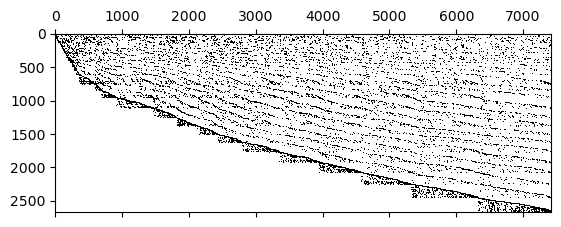

In [8]:
'''
Scipy matricies are werid. Something like 
```
lp_boundry_matrix = boundry_matrix[cycle_rep['index'], bounding_chain['index']]
```
should work, but it doesn't support real indexing without either a slice for the other one or both being the same length

Therfore, you either do something like this
```
# spare matricies are really finicky and don't have great support for index referenceing. therefore, we find slice indicies and use that
cycle_min_i = cycle_rep['index'].min()
cycle_max_i = cycle_rep['index'].max()+1 # upper bound is exclusive
assert (cycle_rep['index'] == np.arange(cycle_min_i, cycle_max_i)).all() # make sure index is a range (so slicing is valid)

bounding_chain_min_i = bounding_chain['index'].min()
bounding_chain_max_i = bounding_chain['index'].max()+1 # upper bound is exclusive
assert (bounding_chain['index'] == np.arange(bounding_chain_min_i, bounding_chain_max_i)).all() # make sure index is a range (so slicing is valid)

# get bounding chain bounds
lp_boundry_matrix = boundry_matrix[cycle_min_i:cycle_max_i, bounding_chain_min_i:bounding_chain_max_i]
```
and use slicing or use the following implentation
'''
lp_boundry_matrix = boundry_matrix[cycle_rep['index'], :][:, bounding_chain['index']]

plt.spy(lp_boundry_matrix, marker=',', c='k')

#### Create the model
Use the `gurobipy` module to create and optimize the model to solve for the bounding chain.

In [17]:
# setup the model
m = gb.Model('Optimal Bounding Chain')

# free (decision) variables
coeffs = m.addMVar((len(bounding_chain)), lb='-INFINITY')
abs_coeffs = m.addMVar((len(bounding_chain)))

# constraints
for i in range(len(bounding_chain)):
    m.addConstr(abs_coeffs[i] == gb.abs_(coeffs[i]), f'abs_{i}')
m.addConstr(lp_boundry_matrix @ coeffs == np.array(cycle_rep['coefficient']), 'boundry') # idk if pandas works with gurobi, im not thinking about it rn tho

# objective
m.setObjective(gb.quicksum(np.array(bounding_chain['filtration']) * abs_coeffs))

# optimize
m.optimize()

# get solution
bounding_chain['coefficient'] = list(map(lambda c: float(c.X), coeffs))

# close model
m.close()

# clean results
optimal_bounding_chain = bounding_chain.loc[bounding_chain['coefficient'] != 0, ['simplex', 'filtration', 'coefficient']].reset_index(drop=True)

optimal_bounding_chain

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 2670 rows, 14842 columns and 22263 nonzeros
Model fingerprint: 0xa249a87c
Model has 7421 general constraints
Variable types: 14842 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve added 13689 rows and 0 columns
Presolve removed 0 rows and 687 columns
Presolve time: 0.04s
Presolved: 16359 rows, 14155 columns, 49789 nonzeros
Variable types: 14155 continuous, 0 integer (0 binary)

Root relaxation: objective 3.772277e+00, 5864 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work


,simplex,filtration,coefficient
0,"[99, 181, 187]",0.851485,-1.0
1,"[99, 187, 267]",0.940594,-1.0
2,"[177, 181, 187]",0.990099,1.0
3,"[177, 187, 267]",0.990099,1.0


In [15]:
# setup the model
m = gb.Model('Optimal Bounding Chain')

# free (decision) variables
pos_coeffs = m.addMVar((len(bounding_chain)))
neg_coeffs = m.addMVar((len(bounding_chain)))

# constraints
m.addConstr(lp_boundry_matrix @ (pos_coeffs-neg_coeffs) == np.array(cycle_rep['coefficient']), 'boundry') # idk if pandas works with gurobi, im not thinking about it rn tho

# objective
m.setObjective(gb.quicksum(np.array(bounding_chain['filtration']) * (pos_coeffs+neg_coeffs)))

# optimize
m.optimize()

# get solution
bounding_chain['coefficient'] = np.array(list(map(lambda c: float(c.X), pos_coeffs))) - np.array(list(map(lambda c: float(c.X), neg_coeffs)))

# close model
m.close()

# clean results
optimal_bounding_chain = bounding_chain.loc[bounding_chain['coefficient'] != 0, ['simplex', 'filtration', 'coefficient']].reset_index(drop=True)

optimal_bounding_chain

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 2670 rows, 14842 columns and 44526 nonzeros
Model fingerprint: 0x705e5c15
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 842 rows and 842 columns
Presolve time: 0.04s
Presolved: 1828 rows, 14000 columns, 37948 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier performed 0 iterations in 0.06 seconds (0.05 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Extra simplex iterations after uncrush: 18
Iteration    Objective       Pri

,simplex,filtration,coefficient
0,"[99, 181, 187]",0.851485,-1.0
1,"[99, 187, 267]",0.940594,-1.0
2,"[177, 181, 187]",0.990099,1.0
3,"[177, 187, 267]",0.990099,1.0


In [ ]:
# optimization problem
start = time()
optimal = factored.optimize_bounding_chain(
        birth_simplex=homology.loc[cycle_i, 'birth simplex']
    )
print(f'Optimizaiton took {time() - start} secs')

# filter the cycle (only include good coeficicents)
dirty_optimal = optimal.loc['optimal cycle', 'chain'] # round all the dumb and bad coefficicents
dirty_optimal['coefficient'] = dirty_optimal['coefficient'].astype(float) # use floats to interact with gurobi
non_optimal_bounding_chain = dirty_optimal[np.logical_not(np.isclose(dirty_optimal['coefficient'], 0, atol=0.1))]

# print the cycle
non_optimal_bounding_chain